In [1]:
import numpy as np
import pandas as pd
import wfdb
import os
import scipy.signal as sgn
from tqdm import tqdm
from keras import models, layers, optimizers, regularizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from scipy.signal import cheby1, filtfilt

In [2]:
# File paths
train_files = [f"a{str(i).zfill(2)}" for i in range(1, 21)] + [f"b{str(i).zfill(2)}" for i in range(1, 6)] + [f"c{str(i).zfill(2)}" for i in range(1, 11)]
test_files = [f"x{str(i).zfill(2)}" for i in range(1, 36)]
base_path = "apnea-ecg/1.0.0/"
train_paths = [os.path.join(base_path, file) for file in train_files]
test_paths = [os.path.join(base_path, file) for file in test_files]


In [3]:
# Data augmentation functions
def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal)) * noise_factor
    return signal + noise

def scale(signal, scaling_factor=0.1):
    scale = np.random.uniform(1 - scaling_factor, 1 + scaling_factor)
    return signal * scale

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    if shift > 0:
        return np.r_[signal[shift:], np.zeros(shift)]
    else:
        return np.r_[np.zeros(-shift), signal[:shift]]

def flip(signal):
    return -signal

def random_dropout(signal, drop_factor=0.1):
    drop_indices = np.random.choice(len(signal), int(len(signal) * drop_factor), replace=False)
    signal_copy = signal.copy()
    signal_copy[drop_indices] = 0
    return signal_copy


# Preprocessing function
def apply_chebyshev_filter(signal, lowcut=0.5, highcut=40, fs=100, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = cheby1(order, 0.5, [low, high], btype='band')
    return filtfilt(b, a, signal)

def load_ecg_and_segment(file, segment_duration=10, fs=100):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'apn')
    signal = record.p_signal[:, 0]
    filtered_signal = apply_chebyshev_filter(signal)
    segments, labels = [], []
    samples_per_segment = segment_duration * fs

    for i, samp in enumerate(annotation.sample):
        start = max(samp - samples_per_segment // 2, 0)
        end = start + samples_per_segment
        if end > len(filtered_signal):
            break
        segment = filtered_signal[start:end]
        segments.append(segment)
        labels.append(1 if annotation.symbol[i] == 'A' else 0)
        
    return np.array(segments), np.array(labels)

# Adjust augment_data to ensure consistent segment length
def augment_data(signal, segment_length=1000):
    augmentations = [add_noise, scale, time_shift, flip, random_dropout]
    augmented_signals = []
    for aug in augmentations:
        augmented_signal = aug(signal)
        # Ensure each augmented signal has the same length
        if len(augmented_signal) > segment_length:
            augmented_signal = augmented_signal[:segment_length]
        elif len(augmented_signal) < segment_length:
            augmented_signal = np.pad(augmented_signal, (0, segment_length - len(augmented_signal)), 'constant')
        augmented_signals.append(augmented_signal)
    return augmented_signals

# Modify prepare_data_with_augmentation to ensure consistent segment length
def prepare_data_with_augmentation(paths, segment_length=1000, augment=True):
    X, y = [], []
    for path in tqdm(paths):
        segments, seg_labels = load_ecg_and_segment(path)
        for i, segment in enumerate(segments):
            # Ensure each original segment has the desired length
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')
            X.append(segment)
            y.append(seg_labels[i])
            
            # Augment if specified
            if augment:
                augmented_segments = augment_data(segment, segment_length=segment_length)
                X.extend(augmented_segments)
                y.extend([seg_labels[i]] * len(augmented_segments))  

    return np.array(X), np.array(y)


In [4]:
from sklearn.utils import shuffle

# Load and augment training data
X_train, y_train = prepare_data_with_augmentation(train_paths, segment_length=1000, augment=True)
X_test, y_test = prepare_data_with_augmentation(test_paths, segment_length=1000, augment=False)


# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Print the number of segments loaded for verification
print(f"Training segments: {len(X_train)}, Test segments: {len(X_test)}")

# Reshape data for model input format
X_train = X_train[..., np.newaxis]  # Adding channel dimension
X_test = X_test[..., np.newaxis]

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:07<00:00,  4.44it/s]


Training segments: 102270, Test segments: 17268
Training data shape: (102270, 1000, 1)
Training labels shape: (102270,)
Test data shape: (17268, 1000, 1)
Test labels shape: (17268,)


In [6]:
# Build CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x_bn = layers.BatchNormalization()(input_layer)
    
    branch1 = layers.Conv1D(24, kernel_size=125, strides=1, activation='relu', padding='same')(x_bn)
    branch1 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(branch1)
    
    branch2 = layers.Conv1D(24, kernel_size=15, strides=1, activation='relu', padding='same')(x_bn)
    branch2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(branch2)
    
    branch3 = layers.Conv1D(24, kernel_size=5, strides=1, activation='relu', padding='same')(x_bn)
    branch3 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(branch3)
    
    concatenated = layers.Concatenate(axis=-1)([branch1, branch2, branch3])
    x = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(concatenated)
    
    conv_adjusted = layers.Conv1D(24, kernel_size=3, strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(conv_adjusted)
    x = layers.Add()([x, conv_adjusted])
    
    x = layers.Dense(48, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(64)(x)
    
    output_layer = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [11]:
from sklearn.model_selection import KFold


# Cross-validation setup
n_splits = 4  # Define number of splits for KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
input_shape = (1000, 1)

# Placeholder for cross-validation results
fold_no = 1
all_scores = []

for train_index, val_index in kf.split(X_train):
    # Split data
    X_ctrain, X_val = X_train[train_index], X_train[val_index]
    y_ctrain, y_val = y_train[train_index], y_train[val_index]
    
    # Build and compile model
    model = build_cnn_lstm_model(input_shape)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
     # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    
    # Train model
    print(f'Training on fold {fold_no}...')
     # Train the model with early stopping
    history = model.fit(
        X_ctrain, y_ctrain,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1] * 100}%")
    all_scores.append(scores[1])
    
    fold_no += 1

# Calculate the average accuracy across folds
average_accuracy = np.mean(all_scores)
print(f'Average cross-validated accuracy: {average_accuracy * 100:.2f}%')

Training on fold 1...
Epoch 1/10
1199/1199 [==============================] - 214s 176ms/step - loss: 0.4678 - accuracy: 0.8087 - val_loss: 0.6031 - val_accuracy: 0.7628
Epoch 2/10
1199/1199 [==============================] - 221s 184ms/step - loss: 0.3500 - accuracy: 0.8516 - val_loss: 0.3326 - val_accuracy: 0.8639
Epoch 3/10
1199/1199 [==============================] - 236s 197ms/step - loss: 0.3298 - accuracy: 0.8617 - val_loss: 0.3715 - val_accuracy: 0.8369
Epoch 4/10
1199/1199 [==============================] - 232s 193ms/step - loss: 0.3149 - accuracy: 0.8690 - val_loss: 0.3123 - val_accuracy: 0.8702
Epoch 5/10
1199/1199 [==============================] - 240s 200ms/step - loss: 0.3065 - accuracy: 0.8730 - val_loss: 0.3060 - val_accuracy: 0.8755
Epoch 6/10
1199/1199 [==============================] - 250s 209ms/step - loss: 0.3008 - accuracy: 0.8759 - val_loss: 0.3046 - val_accuracy: 0.8727
Epoch 7/10
1199/1199 [==============================] - 200s 166ms/step - loss: 0.2928 - a

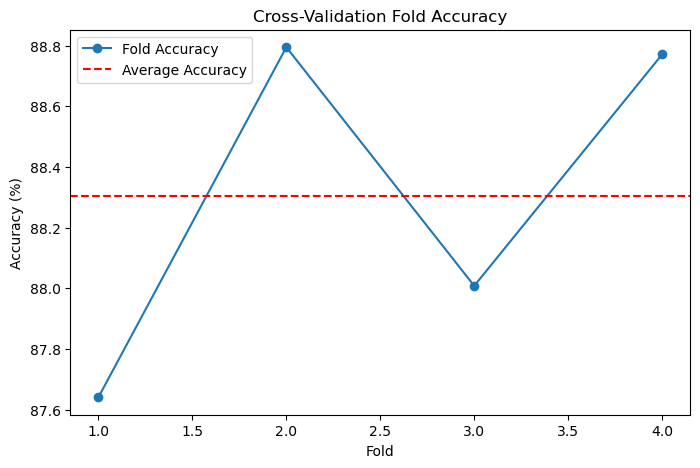

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_scores has cross-validation accuracy for each fold
n_folds = len(all_scores)
fold_indices = range(1, n_folds + 1)

# Plot the cross-validated accuracy for each fold
plt.figure(figsize=(8, 5))
plt.plot(fold_indices, [score * 100 for score in all_scores], marker='o', label='Fold Accuracy')
plt.axhline(np.mean(all_scores) * 100, color='r', linestyle='--', label='Average Accuracy')
plt.title('Cross-Validation Fold Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [17]:
# (This part will work only if you have a model ready for testing)
test_scores = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_scores[1] * 100:.2f}%")

540/540 [==============================] - 7s 14ms/step - loss: 0.6426 - accuracy: 0.7260
Test Accuracy: 72.60%


In [18]:
from sklearn.metrics import cohen_kappa_score

# Assuming `y_test` are the true labels and `y_pred` are the predicted labels from the model
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels

# Calculate Kappa Score
kappa_score = cohen_kappa_score(y_test, y_pred_classes)
print(f"Cohen's Kappa Score: {kappa_score:.2f}")

540/540 [==============================] - 8s 14ms/step
Cohen's Kappa Score: 0.43
